In [89]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import os
import pandas as pd
from shapely.ops import unary_union

In [3]:
# define the place name for the west midlands area
place_name = "West midlands, UK"
# download the road network data from osmnx from the OSM API
RoadNetworkGraph = ox.graph_from_place(place_name, network_type='drive')
print(f"Original CRS: {RoadNetworkGraph.graph['crs']}")
# project the road network to the British National Grid (EPSG:27700)
RoadNetworkGraph_projected = ox.project_graph(RoadNetworkGraph, to_crs='EPSG:27700')
# check the CRS
print(f"Projected CRS: {RoadNetworkGraph_projected.graph['crs']}")

Original CRS: epsg:4326
Projected CRS: EPSG:27700


In [ ]:
# save the graph as a file
#nx.write_graphml_lxml(RoadNetworkGraph, "data/RoadNetwork.graph")

In [11]:
# check how many nodes and edges in the graph
print(f"Number of nodes: {len(RoadNetworkGraph_projected.nodes)}")
print(f"Number of edges: {len(RoadNetworkGraph_projected.edges)}")

Number of nodes: 83323
Number of edges: 184282


In [12]:
# check if the network is a directed graph
print(f"Is the graph directed? {nx.is_directed(RoadNetworkGraph_projected)}")

Is the graph directed? True


In [47]:
# change the graph to an undirected graph
RoadNetworkGraph_undirected = RoadNetworkGraph_projected.to_undirected()

In [58]:
# check if the network is fully connected
print(f"Is the graph fully connected? {nx.is_connected(RoadNetworkGraph_undirected)}")

Is the graph fully connected? True


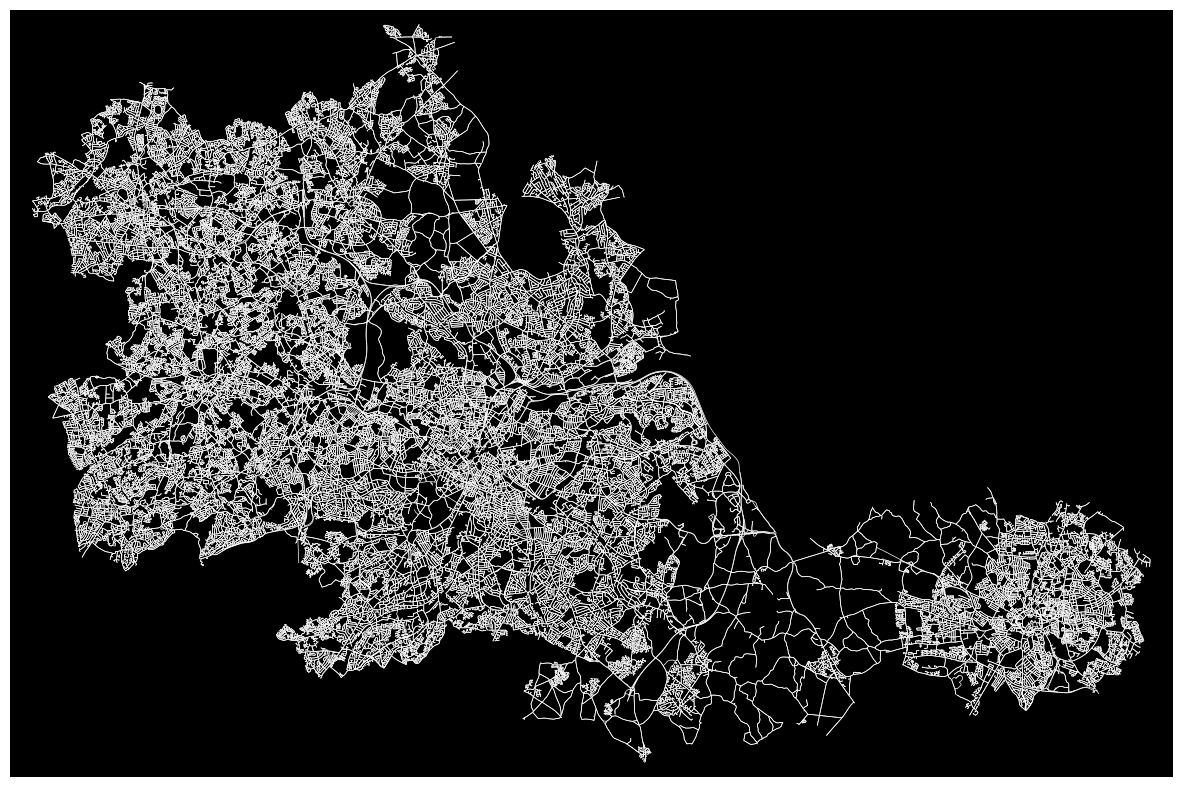

(<Figure size 1500x1500 with 1 Axes>, <Axes: >)

In [48]:
# plot the graph, figure size is 2000x2000 pixels
ox.plot_graph(RoadNetworkGraph_projected, figsize=(15, 15), bgcolor='k', node_size=0, edge_linewidth=0.5, edge_color='w')

In [49]:
station_csv = pd.read_csv(os.path.join("data","processed","station_locations_38.csv"))
# create a geometry column from the Easting and Northing columns
station_csv['geometry'] = station_csv.apply(lambda x: Point(x['Easting'], x['Northing']), axis=1)
# create a GeoDataFrame from the CSV file
stations_gdf = gpd.GeoDataFrame(station_csv, crs='epsg:27700')

In [50]:
stations_gdf.head()

,Station name,Easting,Northing,PRL_Count,BRV_Count,Closed (Y/N),Opened,Closed,geometry
0,Aldridge,405203,302818,1,0,N,Before study period,NaN,POINT (405203.000 302818.000)
1,Aston,407316,289711,1,1,N,Before study period,NaN,POINT (407316.000 289711.000)
2,Bickenhill,419627,284038,1,0,N,Before study period,NaN,POINT (419627.000 284038.000)
3,Billesley,409029,281369,1,1,N,Before study period,NaN,POINT (409029.000 281369.000)
4,Bilston,394543,296040,1,0,N,Before study period,NaN,POINT (394543.000 296040.000)


**Calculate the distance threshold based on histocial data**

In [51]:
mobilisation = pd.read_csv(os.path.join("data","processed","mobilisation_14_22.csv"))
mobilisation.columns

Index(['Incident_Number', 'callsign_type', 'call_time', 'callsign_station',
       'initial_incident_type', 'incident_classification_label',
       'incident_profile_label', 'incident_classification_level1',
       'call_seconds', 'reaction_seconds', 'driving_seconds',
       'on_scene_seconds', 'EASTINGS', 'NORTHINGS', 'call_hour', 'call_day',
       'call_month', 'call_year', 'Station name', 'Sta_Easting',
       'Sta_Northing', 'PRL_Count', 'BRV_Count', 'Closed (Y/N)', 'Opened',
       'Closed'],
      dtype='object')

In [52]:
mobilisation['response_time'] = mobilisation['call_seconds']+mobilisation['reaction_seconds']+mobilisation['driving_seconds']

In [53]:
# check the proportion of rows where response time is less than 600

print(f"Proportion of call_seconds times less than 600 seconds: {len(mobilisation[mobilisation['call_seconds'] < 600]) / len(mobilisation)}")
print(f"Proportion of reaction_seconds times less than 600 seconds: {len(mobilisation[mobilisation['reaction_seconds'] < 600]) / len(mobilisation)}")
print(f"Proportion of driving_seconds less than 600 seconds: {len(mobilisation[mobilisation['driving_seconds'] < 600]) / len(mobilisation)}")
print(f"Proportion of response times less than 600 seconds: {len(mobilisation[mobilisation['response_time'] < 600]) / len(mobilisation)}")

Proportion of call_seconds times less than 600 seconds: 0.937115368505165
Proportion of reaction_seconds times less than 600 seconds: 0.9984953054819855
Proportion of driving_seconds less than 600 seconds: 0.9052590201119982
Proportion of response times less than 600 seconds: 0.729841282115723


In [69]:
# define a function to get the nearest node
def get_nearest_node(graph, point):
    return ox.distance.nearest_nodes(graph, point[0], point[1])
# filter all rows where the response time is 300 seconds
mobilisation_5min = mobilisation[(mobilisation['driving_seconds'] == 300)]
mobilisation_5min['INCI_coordinates'] = list(zip(mobilisation_5min['EASTINGS'], mobilisation_5min['NORTHINGS']))
mobilisation_5min['STA_coordinates'] = list(zip(mobilisation_5min['Sta_Easting'], mobilisation_5min['Sta_Northing']))
# get the nearest node for the station and incident coordinates
mobilisation_5min['STA_node'] = mobilisation_5min['STA_coordinates'].apply(lambda x: get_nearest_node(RoadNetworkGraph_undirected, x))
mobilisation_5min['INCI_node'] = mobilisation_5min['INCI_coordinates'].apply(lambda x: get_nearest_node(RoadNetworkGraph_undirected, x))

# calculate the network distance between the station and the incident
mobilisation_5min['network_distance'] = mobilisation_5min.apply(
    lambda x: nx.shortest_path_length(RoadNetworkGraph_undirected, source=x['STA_node'], target=x['INCI_node'], weight='length'),
    axis=1
)
# calculate the mean network distance as the 10min service area's radius
mean_network_distance = mobilisation_5min['network_distance'].mean()
print(f"Mean network distance for 5min: {mean_network_distance}")

C:\Users\SBH\AppData\Local\Temp\ipykernel_13364\2239349593.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mobilisation_5min['INCI_coordinates'] = list(zip(mobilisation_5min['EASTINGS'], mobilisation_5min['NORTHINGS']))
C:\Users\SBH\AppData\Local\Temp\ipykernel_13364\2239349593.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mobilisation_5min['STA_coordinates'] = list(zip(mobilisation_5min['Sta_Easting'], mobilisation_5min['Sta_Northing']))
C:\Users\SBH\AppData\Local\Temp\ipykernel_13364\2239349593.

Mean network distance for 5min: 3368.877492810457


C:\Users\SBH\AppData\Local\Temp\ipykernel_13364\2239349593.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mobilisation_5min['network_distance'] = mobilisation_5min.apply(


In [176]:
mobilisation_5min.shape

(765, 32)

In [72]:
# filter all rows where the response time is less than 660 seconds and bigger than 540 seconds
mobilisation_10min = mobilisation[(mobilisation['driving_seconds'] == 600)]
mobilisation_10min.shape

(126, 27)

In [73]:
# create a coordinate column from the Easting and Northing columns
mobilisation_10min['INCI_coordinates'] = list(zip(mobilisation_10min['EASTINGS'], mobilisation_10min['NORTHINGS']))
mobilisation_10min['STA_coordinates'] = list(zip(mobilisation_10min['Sta_Easting'], mobilisation_10min['Sta_Northing']))

C:\Users\SBH\AppData\Local\Temp\ipykernel_13364\4256618967.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mobilisation_10min['INCI_coordinates'] = list(zip(mobilisation_10min['EASTINGS'], mobilisation_10min['NORTHINGS']))
C:\Users\SBH\AppData\Local\Temp\ipykernel_13364\4256618967.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mobilisation_10min['STA_coordinates'] = list(zip(mobilisation_10min['Sta_Easting'], mobilisation_10min['Sta_Northing']))


In [74]:
# define a function to get the nearest node
def get_nearest_node(graph, point):
    return ox.distance.nearest_nodes(graph, point[0], point[1])

# get the nearest node for the station and incident coordinates
mobilisation_10min['STA_node'] = mobilisation_10min['STA_coordinates'].apply(lambda x: get_nearest_node(RoadNetworkGraph_undirected, x))
mobilisation_10min['INCI_node'] = mobilisation_10min['INCI_coordinates'].apply(lambda x: get_nearest_node(RoadNetworkGraph_undirected, x))

# calculate the network distance between the station and the incident
mobilisation_10min['network_distance'] = mobilisation_10min.apply(
    lambda x: nx.shortest_path_length(RoadNetworkGraph_undirected, source=x['STA_node'], target=x['INCI_node'], weight='length'),
    axis=1
)

# calculate the mean network distance as the 10min service area's radius
mean_network_distance = mobilisation_10min['network_distance'].mean()
print(f"Mean network distance: {mean_network_distance}")

C:\Users\SBH\AppData\Local\Temp\ipykernel_13364\176771776.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mobilisation_10min['STA_node'] = mobilisation_10min['STA_coordinates'].apply(lambda x: get_nearest_node(RoadNetworkGraph_undirected, x))
C:\Users\SBH\AppData\Local\Temp\ipykernel_13364\176771776.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mobilisation_10min['INCI_node'] = mobilisation_10min['INCI_coordinates'].apply(lambda x: get_nearest_node(RoadNetworkGraph_undirected, x))


Mean network distance: 6004.65865079365


C:\Users\SBH\AppData\Local\Temp\ipykernel_13364\176771776.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mobilisation_10min['network_distance'] = mobilisation_10min.apply(


In [75]:
# Example GeoDataFrame with stations
# Replace this with your actual data


# Calculate the 6004m coverage area(10min) for each station
coverage_areas = []
for idx, row in stations_gdf.iterrows():
    station_point = row['geometry']
    station_id = row['Station name']
    # Find the nearest node in the road network
    nearest_node = ox.distance.nearest_nodes(RoadNetworkGraph_undirected, X=station_point.x, Y=station_point.y)
    # Calculate the coverage area
    subgraph = nx.ego_graph(RoadNetworkGraph_undirected, nearest_node, radius=6004, distance='length')
    # Convert the subgraph to a polygon
    nodes, edges = ox.graph_to_gdfs(subgraph)
    coverage_polygon = edges.unary_union.convex_hull
    coverage_areas.append({'station_id': station_id, 'geometry': coverage_polygon})

# Create a GeoDataFrame for the coverage areas
coverage_10min_gdf = gpd.GeoDataFrame(coverage_areas, crs='EPSG:27700')


In [76]:
# Calculate the 3368m coverage area(5min) for each station
coverage_areas = []
for idx, row in stations_gdf.iterrows():
    station_point = row['geometry']
    station_id = row['Station name']
    # Find the nearest node in the road network
    nearest_node = ox.distance.nearest_nodes(RoadNetworkGraph_undirected, X=station_point.x, Y=station_point.y)
    # Calculate the coverage area
    subgraph = nx.ego_graph(RoadNetworkGraph_undirected, nearest_node, radius=3368, distance='length')
    # Convert the subgraph to a polygon
    nodes, edges = ox.graph_to_gdfs(subgraph)
    coverage_polygon = edges.unary_union.convex_hull
    coverage_areas.append({'station_id': station_id, 'geometry': coverage_polygon})

# Create a GeoDataFrame for the coverage areas
coverage_5min_gdf = gpd.GeoDataFrame(coverage_areas, crs='EPSG:27700')

In [77]:
# check if all data are in the same coordinate system
print(f"Stations CRS: {stations_gdf.crs}")
print(f"coverage_5min_gdf CRS: {coverage_5min_gdf.crs}")
print(f"coverage_10min_gdf CRS: {coverage_10min_gdf.crs}")
print(f"Road Network CRS: {RoadNetworkGraph_undirected.graph['crs']}")

Stations CRS: epsg:27700
coverage_5min_gdf CRS: EPSG:27700
coverage_10min_gdf CRS: EPSG:27700
Road Network CRS: EPSG:27700


In [78]:
# import the shp file for the bournoundaries
Area_boundary = gpd.read_file(os.path.join("data/westmidslands/westmidlands.shp"))

C:\Users\SBH\AppData\Local\Temp\ipykernel_13364\4029193129.py:15: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


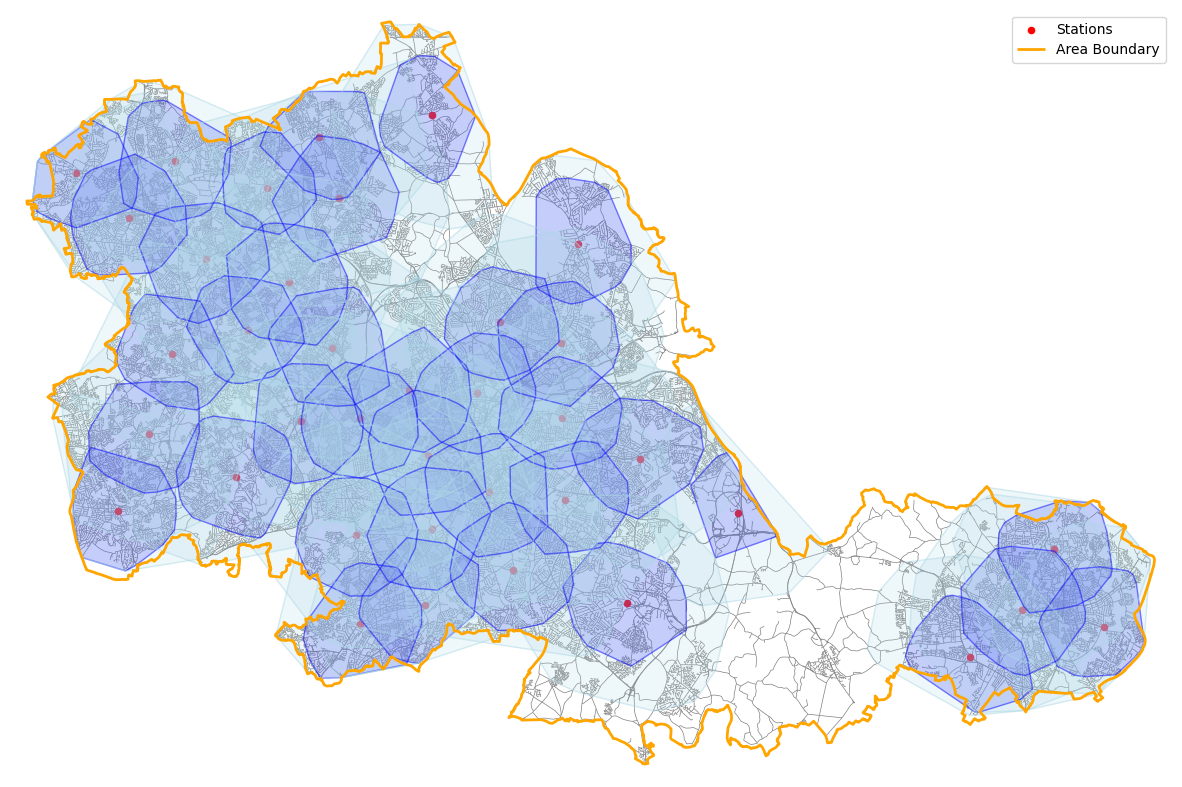

In [79]:
# 可视化结果
fig, ax = plt.subplots(figsize=(15, 15))
# 绘制路网
ox.plot_graph(RoadNetworkGraph_undirected, ax=ax, node_size=0, edge_linewidth=0.5, edge_color='gray', show=False, close=False)
# 绘制站点
stations_gdf.plot(ax=ax, color='red', markersize=20, label='Stations')
# 绘制覆盖区域, 边界为浅蓝色，透明度为0.5，填充为浅蓝色，透明度为0.2，边界宽度为1,边界线型为短划线
coverage_5min_gdf.boundary.plot(ax=ax, edgecolor='blue', linewidth=1, alpha=0.5)
coverage_10min_gdf.boundary.plot(ax=ax, edgecolor='lightblue', linewidth=1, alpha=0.5)
coverage_5min_gdf.plot(ax=ax, color='blue', alpha=0.2, label='5min Coverage Area')
coverage_10min_gdf.plot(ax=ax, color='lightblue', alpha=0.2, label='10min Coverage Area')
# 绘制研究区域的边界
Area_boundary.boundary.plot(ax=ax, edgecolor='orange', linewidth=2, label='Area Boundary')
# 添加图例
plt.legend()
# 显示图形
plt.show()

In [92]:
coverage_10min_union_result = gpd.GeoDataFrame(geometry=[unary_union(coverage_10min_gdf.geometry)], crs='EPSG:27700')
coverage_5min_union_result = gpd.GeoDataFrame(geometry=[unary_union(coverage_5min_gdf.geometry)], crs='EPSG:27700')
clipped_coverage_10min = coverage_10min_union_result.intersection(Area_boundary)
clipped_coverage_5min = coverage_5min_union_result.intersection(Area_boundary)

In [100]:
## calculate the original service coverage area
cov_10min_area_ratio = clipped_coverage_10min.area/Area_boundary.area
cov_5min_area_ratio = clipped_coverage_5min.area/Area_boundary.area
print(f"10min coverage area ratio: {cov_10min_area_ratio}, 5min coverage area ratio: {cov_5min_area_ratio}")

10min coverage area ratio: 0    0.894456
dtype: float64, 5min coverage area ratio: 0    0.672786
dtype: float64


In [106]:
# check the type of cov_10min_area_ratio
type(cov_10min_area_ratio)
# convert the ratio to a float
cov_10min_area_ratio = cov_10min_area_ratio.values[0]

0    0.894456
dtype: float64

In [83]:
# create the station list for the further closure iteration
station_list = station_csv['Station name'].tolist()
len(station_list)

38

## N = 1

In [122]:
calc_station_csv = station_csv.copy()
# add a new column called "new ratio"   to store the new coverage area ratio
calc_station_csv['new_ratio_10min'] = 0.0
calc_station_csv['new_ratio_5min'] = 0.0

In [125]:

# create a gdf after deleting the certain station
for station_name in station_list:
    gdf_10min = coverage_10min_gdf.copy()
    gdf_5min = coverage_5min_gdf.copy()
    gdf_10min = gdf_10min[gdf_10min['station_id']!=station_name]
    gdf_5min = gdf_5min[gdf_5min['station_id']!=station_name]
    # 使用 unary_union 函数计算所有面要素的并集
    union_result_10min = unary_union(gdf_10min.geometry)
    union_result_5min = unary_union(gdf_5min.geometry)

    # 将结果转换为 GeoDataFrame 以便后续使用
    result_gdf_10min = gpd.GeoDataFrame(geometry=[union_result_10min], crs="27700")
    result_gdf_5min = gpd.GeoDataFrame(geometry=[union_result_5min], crs="27700")

    # 用另外一个边界gdf裁剪这个结果
    clipped_result_10min = result_gdf_10min.intersection(Area_boundary)
    clipped_result_5min = result_gdf_5min.intersection(Area_boundary)

    # 计算这个clipped_result的面积与Area_boundary的面积的比值
    area_ratio_10min = clipped_result_10min.area / Area_boundary.area
    area_ratio_5min = clipped_result_5min.area / Area_boundary.area


    calc_station_csv.loc[calc_station_csv['Station name'] == station_name, 'new_ratio_10min'] = area_ratio_10min.values[0]
    calc_station_csv.loc[calc_station_csv['Station name'] == station_name, 'new_ratio_5min'] = area_ratio_5min.values[0]


# calculate the difference between the original ratio and the new ratio
calc_station_csv['diff_10min'] = cov_10min_area_ratio.values[0] - calc_station_csv['new_ratio_10min']
calc_station_csv['diff_5min'] = cov_5min_area_ratio.values[0] - calc_station_csv['new_ratio_5min']

In [166]:
n1_result = calc_station_csv.copy()

# order the result by the 'diff_5min' column in descending order
n1_result = n1_result.sort_values(by='diff_5min', ascending=True)
n1_result.head(8)

,Station name,Easting,Northing,PRL_Count,BRV_Count,Closed (Y/N),Opened,Closed,geometry,new_ratio_10min,new_ratio_5min,diff_10min,diff_5min
7,Bournbrook,405167,283287,1,0,N,Before study period,NaN,POINT (405167 283287),0.894456,0.670686,0.000000,0.002099
25,Smethwick,401805,288545,1,0,N,Before study period,NaN,POINT (401805 288545),0.894456,0.670594,0.000000,0.002192
20,Ladywood,404983,286788,1,1,N,Before study period,NaN,POINT (404983 286788),0.894456,0.670489,0.000000,0.002297
18,Highgate,407895,285024,2,0,N,Before study period,NaN,POINT (407895 285024),0.894456,0.668514,0.000000,0.004271
1,Aston,407316,289711,1,1,N,Before study period,NaN,POINT (407316 289711),0.894456,0.668313,0.000000,0.004473
16,Handsworth,404124,289867,1,1,N,Before study period,NaN,POINT (404124 289867),0.894456,0.667613,0.000000,0.005173
19,Kings Norton,404865,279690,1,0,N,Before study period,NaN,POINT (404865 279690),0.894369,0.666247,0.000087,0.006539
30,Tipton,396494,292683,1,0,N,Before study period,NaN,POINT (396494 292683),0.894456,0.665978,0.000000,0.006808


## N = 2

In [136]:
# generate a list where take every 2 stations as a combination among all stations
station_combinations_2 = []

for i in range(len(station_list)):
    for j in range(i+1, len(station_list)):
        station_combinations_2.append([station_list[i], station_list[j]])

len(station_combinations_2)


703

In [146]:
# convert the station_combinations_2 list to a DataFrame
station_combinations_2_df = pd.DataFrame(station_combinations_2, columns=['station_1', 'station_2'])
station_combinations_2_df['new_ratio_10min'] = 0.0
station_combinations_2_df['new_ratio_5min'] = 0.0

In [153]:
# create a gdf after deleting the certain station
for station_name in station_combinations_2:
    gdf_10min = coverage_10min_gdf.copy()
    gdf_5min = coverage_5min_gdf.copy()
    gdf_10min = gdf_10min[(gdf_10min['station_id'] != station_name[0]) & (gdf_10min['station_id'] != station_name[1])]
    gdf_5min = gdf_5min[(gdf_5min['station_id'] != station_name[0]) & (gdf_5min['station_id'] != station_name[1])]

    # 使用 unary_union 函数计算所有面要素的并集
    union_result_10min = unary_union(gdf_10min.geometry)
    union_result_5min = unary_union(gdf_5min.geometry)

    # 将结果转换为 GeoDataFrame 以便后续使用
    result_gdf_10min = gpd.GeoDataFrame(geometry=[union_result_10min], crs="27700")
    result_gdf_5min = gpd.GeoDataFrame(geometry=[union_result_5min], crs="27700")

    # 用另外一个边界gdf裁剪这个结果
    clipped_result_10min = result_gdf_10min.intersection(Area_boundary)
    clipped_result_5min = result_gdf_5min.intersection(Area_boundary)

    # 计算这个clipped_result的面积与Area_boundary的面积的比值
    area_ratio_10min = clipped_result_10min.area / Area_boundary.area
    area_ratio_5min = clipped_result_5min.area / Area_boundary.area


    station_combinations_2_df.loc[
    (station_combinations_2_df['station_1'] == station_name[0]) & 
    (station_combinations_2_df['station_2'] == station_name[1]), 
    'new_ratio_10min'
    ] = area_ratio_10min.values[0]

    station_combinations_2_df.loc[
    (station_combinations_2_df['station_1'] == station_name[0]) & 
    (station_combinations_2_df['station_2'] == station_name[1]), 
    'new_ratio_5min'
    ] = area_ratio_5min.values[0]

# calculate the difference between the original ratio and the new ratio
station_combinations_2_df['diff_10min'] = cov_10min_area_ratio.values[0] - station_combinations_2_df['new_ratio_10min']
station_combinations_2_df['diff_5min'] = cov_5min_area_ratio.values[0] - station_combinations_2_df['new_ratio_5min']

In [167]:
n2_result = station_combinations_2_df.copy()

# order the result by the 'diff_5min' column in descending order
n2_result = n2_result.sort_values(by='diff_5min', ascending=True)
n2_result.head(7)

,station_1,station_2,new_ratio_10min,new_ratio_5min,diff_10min,diff_5min
255,Bournbrook,Smethwick,0.894456,0.668494,0.0,0.004291
519,Highgate,Smethwick,0.894456,0.666322,0.0,0.006463
42,Aston,Bournbrook,0.894456,0.666214,0.0,0.006572
60,Aston,Smethwick,0.894456,0.666121,0.0,0.006665
554,Ladywood,Smethwick,0.894456,0.666002,0.0,0.006784
250,Bournbrook,Ladywood,0.894456,0.665689,0.0,0.007097
246,Bournbrook,Handsworth,0.894456,0.665513,0.0,0.007273


In [168]:
n2_result = station_combinations_2_df.copy()

# order the result by the 'diff_5min' column in descending order
n2_result = n2_result.sort_values(by='diff_10min', ascending=True)
n2_result.head(7)

,station_1,station_2,new_ratio_10min,new_ratio_5min,diff_10min,diff_5min
629,Smethwick,Tipton,0.894456,0.663786,0.0,0.009000
247,Bournbrook,Hay Mills,0.894456,0.660194,0.0,0.012591
519,Highgate,Smethwick,0.894456,0.666322,0.0,0.006463
263,Bournbrook,Wednesbury,0.894456,0.662435,0.0,0.010350
472,Handsworth,Hay Mills,0.894456,0.657121,0.0,0.015665
39,Aston,Bilston,0.894456,0.655846,0.0,0.016940
246,Bournbrook,Handsworth,0.894456,0.665513,0.0,0.007273


## N=3

In [159]:
# generate a list where take every 3 stations as a combination among all stations

station_combinations_3 = []

for i in range(len(station_list)):
    for j in range(i+1, len(station_list)):
        for k in range(j+1, len(station_list)):
            station_combinations_3.append([station_list[i], station_list[j], station_list[k]])

len(station_combinations_3)


8436

In [160]:
# convert the station_combinations_3 list to a DataFrame
station_combinations_3_df = pd.DataFrame(station_combinations_3, columns=['station_1', 'station_2', 'station_3'])
station_combinations_3_df['new_ratio_10min'] = 0.0
station_combinations_3_df['new_ratio_5min'] = 0.0

In [161]:
# create a gdf after deleting the certain station
for station_name in station_combinations_3:
    gdf_10min = coverage_10min_gdf.copy()
    gdf_5min = coverage_5min_gdf.copy()
    gdf_10min = gdf_10min[(gdf_10min['station_id'] != station_name[0]) & (gdf_10min['station_id'] != station_name[1]) & (gdf_10min['station_id'] != station_name[2])]
    gdf_5min = gdf_5min[(gdf_5min['station_id'] != station_name[0]) & (gdf_5min['station_id'] != station_name[1]) & (gdf_5min['station_id'] != station_name[2])]

    # 使用 unary_union 函数计算所有面要素的并集
    union_result_10min = unary_union(gdf_10min.geometry)
    union_result_5min = unary_union(gdf_5min.geometry)

    # 将结果转换为 GeoDataFrame 以便后续使用
    result_gdf_10min = gpd.GeoDataFrame(geometry=[union_result_10min], crs="27700")
    result_gdf_5min = gpd.GeoDataFrame(geometry=[union_result_5min], crs="27700")

    # 用另外一个边界gdf裁剪这个结果
    clipped_result_10min = result_gdf_10min.intersection(Area_boundary)
    clipped_result_5min = result_gdf_5min.intersection(Area_boundary)

    # 计算这个clipped_result的面积与Area_boundary的面积的比值
    area_ratio_10min = clipped_result_10min.area / Area_boundary.area
    area_ratio_5min = clipped_result_5min.area / Area_boundary.area



    station_combinations_3_df.loc[
    (station_combinations_3_df['station_1'] == station_name[0]) & 
    (station_combinations_3_df['station_2'] == station_name[1]) &
    (station_combinations_3_df['station_3'] == station_name[2]), 
    'new_ratio_10min'
    ] = area_ratio_10min.values[0]

    station_combinations_3_df.loc[
    (station_combinations_3_df['station_1'] == station_name[0]) & 
    (station_combinations_3_df['station_2'] == station_name[1]) &
    (station_combinations_3_df['station_3'] == station_name[2]), 
    'new_ratio_5min'
    ] = area_ratio_5min.values[0]

# calculate the difference between the original ratio and the new ratio
station_combinations_3_df['diff_10min'] = cov_10min_area_ratio.values[0] - station_combinations_3_df['new_ratio_10min']
station_combinations_3_df['diff_5min'] = cov_5min_area_ratio.values[0] - station_combinations_3_df['new_ratio_5min']

In [169]:
n3_result = station_combinations_3_df.copy()

# order the result by the 'diff_5min' column in descending order
n3_result = n3_result.sort_values(by='diff_5min', ascending=True)
n3_result.head(7)

,station_1,station_2,station_3,new_ratio_10min,new_ratio_5min,diff_10min,diff_5min
848,Aston,Bournbrook,Smethwick,0.894456,0.664022,0.0,0.008764
4302,Bournbrook,Smethwick,Tipton,0.894456,0.661687,0.0,0.011099
4192,Bournbrook,Highgate,Smethwick,0.894456,0.661395,0.0,0.011390
4227,Bournbrook,Ladywood,Smethwick,0.894456,0.661202,0.0,0.011584
1112,Aston,Highgate,Smethwick,0.894456,0.660969,0.0,0.011817
4153,Bournbrook,Handsworth,Smethwick,0.894456,0.660553,0.0,0.012233
1147,Aston,Ladywood,Smethwick,0.894456,0.660449,0.0,0.012336


In [170]:
n3_result = station_combinations_3_df.copy()

# order the result by the 'diff_5min' column in descending order
n3_result = n3_result.sort_values(by='diff_10min', ascending=True)
n3_result.head(7)

,station_1,station_2,station_3,new_ratio_10min,new_ratio_5min,diff_10min,diff_5min
7357,Highgate,Oldbury,Wednesbury,0.894456,0.652163,0.0,0.020623
1120,Aston,Highgate,Wednesbury,0.894456,0.654910,0.0,0.017876
1117,Aston,Highgate,Tipton,0.894456,0.656353,0.0,0.016432
7396,Highgate,Smethwick,Wednesbury,0.894456,0.658071,0.0,0.014714
7393,Highgate,Smethwick,Tipton,0.894456,0.659515,0.0,0.013271
1112,Aston,Highgate,Smethwick,0.894456,0.660969,0.0,0.011817
1109,Aston,Highgate,Oldbury,0.894456,0.655060,0.0,0.017725


In [171]:
# generate a list where take every 4 stations as a combination among all stations


station_combinations_4 = []

for i in range(len(station_list)):
    for j in range(i+1, len(station_list)):
        for k in range(j+1, len(station_list)):
            for l in range(k+1, len(station_list)):
                station_combinations_4.append([station_list[i], station_list[j], station_list[k], station_list[l]])

len(station_combinations_4)


73815